In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns


from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import GradsHistHandler, GradsScalarHandler, OptimizerParamsHandler, OutputHandler, WeightsHistHandler, WeightsScalarHandler, global_step_from_engine

In [2]:
# Configuration Variables
MEAN_PREPRO = [0.485, 0.456, 0.406]
STD_PREPRO = [0.229, 0.224, 0.225]
RESIZE_PREPRO = 256,256

TRAIN_BATCH_SIZE = 256
TRAIN_SHUFFLE = True
TRAIN_NUM_WORKERS = 8
TRAIN_PIN_MEMORY = True

VAL_BATCH_SIZE = 1024
VAL_SHUFFLE = False
VAL_NUM_WORKERS = 8
VAL_PIN_MEMORY = True

N_CLASSES = 5

INITIAL_LR = 1e-4
DEVICE_ID = 1

EARLY_STOPPING_PATIENCE=10

MAX_EPOCHS = 30

DATA_DIR = '/data/porn/data'
TRAINSET_ROOT = f'{DATA_DIR}/train'
TESTSET_ROOT = f'{DATA_DIR}/test'

TENSORBOARD_DIR = '/data/porn/tensorboard'

In [3]:
normalize = transforms.Normalize(
        mean=MEAN_PREPRO, std=STD_PREPRO
    )
prepro = transforms.Compose(
    [
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]
)
prepro_val = transforms.Compose(
    [transforms.Resize(RESIZE_PREPRO), transforms.ToTensor(), normalize]
)

In [4]:
trainset = ImageFolder(TRAINSET_ROOT, transform=prepro)
print(trainset)
print(trainset.classes)

Dataset ImageFolder
    Number of datapoints: 182535
    Root location: /data/porn/data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['drawings', 'hentai', 'neutral', 'porn', 'sexy']


In [5]:
valset = ImageFolder(TESTSET_ROOT, transform=prepro_val)
print(valset)
print(valset.classes)

Dataset ImageFolder
    Number of datapoints: 9187
    Root location: /data/porn/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['drawings', 'hentai', 'neutral', 'porn', 'sexy']


In [6]:
train_loader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=TRAIN_SHUFFLE, num_workers=TRAIN_NUM_WORKERS,pin_memory=TRAIN_PIN_MEMORY)
val_loader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=VAL_SHUFFLE, num_workers=VAL_NUM_WORKERS,pin_memory=VAL_PIN_MEMORY)

In [7]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, N_CLASSES)
device = f"cuda:{DEVICE_ID}"
model = model.to(device)
for p in model.parameters():
    p.requires_grad=False
for p in model.fc.parameters():
    p.requires_grad=True

In [8]:
from ignite.contrib.handlers.param_scheduler import LRScheduler
from torch.optim.lr_scheduler import MultiStepLR

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=INITIAL_LR)
criterion = nn.CrossEntropyLoss()

step_scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)
scheduler = LRScheduler(step_scheduler)

In [9]:
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
trainer.add_event_handler(Events.EPOCH_COMPLETED, scheduler)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=5)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [10]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [11]:
@trainer.on(Events.ITERATION_COMPLETED(every=50))
def log_training_iteration(engine):
    print("{} / {} : {}/{} - loss: {:.2f}"
          .format(engine.state.epoch, engine.state.max_epochs, engine.state.iteration, engine.state.epoch_length, engine.state.output))

In [12]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    train_evaluator.run(train_loader)
    val_evaluator.run(val_loader)

In [13]:
@val_evaluator.on(Events.ITERATION_COMPLETED(every=50))
def log_training_iteration(engine):
    print("{} / {} : {}/{} - loss: {:.2f}"
          .format(engine.state.epoch, engine.state.max_epochs, engine.state.iteration, engine.state.epoch_length, engine.state.output))

In [14]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['drawings', 'hentai', 'neutral', 'porn', 'sexy']
    fig, ax = plt.subplots(figsize=(5,5))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [15]:
checkpointer = ModelCheckpoint('./saved_models', 'porn', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})

In [18]:
logger = TensorboardLogger(TENSORBOARD_DIR)
logger.attach(
    trainer,
    log_handler=OutputHandler(tag="training", metric_names="all"),
    event_name=Events.ITERATION_COMPLETED,
)
# Attach the logger to the trainer to log training loss at each iteration
logger.attach(
    trainer,
    log_handler=OutputHandler(
        tag="training", output_transform=lambda l: {"loss": l}
    ),
    event_name=Events.ITERATION_COMPLETED,
)

# Attach the logger to the trainer to log optimizer's parameters, e.g. learning rate at each iteration
logger.attach(
    trainer,
    log_handler=OptimizerParamsHandler(optimizer),
    event_name=Events.ITERATION_STARTED,
)
logger.attach(
    train_evaluator,
    log_handler=OutputHandler(
        tag="trainval",
        metric_names=["accuracy", "nll"],
        global_step_transform=global_step_from_engine(trainer),
    ),
    event_name=Events.EPOCH_COMPLETED,
)
logger.attach(
    val_evaluator,
        log_handler=OutputHandler(
            tag="validation",
            metric_names="all",
            global_step_transform=global_step_from_engine(trainer),
        ),
    event_name=Events.EPOCH_COMPLETED,
)

2 / 5 : 50/714 - loss: 1.08
2 / 5 : 100/714 - loss: 0.95
2 / 5 : 150/714 - loss: 0.82
2 / 5 : 200/714 - loss: 0.75
2 / 5 : 250/714 - loss: 0.66
2 / 5 : 300/714 - loss: 0.67
2 / 5 : 350/714 - loss: 0.62
2 / 5 : 400/714 - loss: 0.61
2 / 5 : 450/714 - loss: 0.57
2 / 5 : 500/714 - loss: 0.53
2 / 5 : 550/714 - loss: 0.50
2 / 5 : 600/714 - loss: 0.51
2 / 5 : 650/714 - loss: 0.50
2 / 5 : 700/714 - loss: 0.51


/opt/conda/lib/python3.7/site-packages/ignite/contrib/handlers/tensorboard_logger.py:120: UserWarning: TensorboardLogger output_handler can not log metrics value type <class 'torch.Tensor'>
  "metrics value type {}".format(type(value)))


3 / 5 : 750/714 - loss: 0.52
3 / 5 : 800/714 - loss: 0.47
3 / 5 : 850/714 - loss: 0.39
3 / 5 : 900/714 - loss: 0.43
3 / 5 : 950/714 - loss: 0.45
3 / 5 : 1000/714 - loss: 0.47
3 / 5 : 1050/714 - loss: 0.40
3 / 5 : 1100/714 - loss: 0.37
3 / 5 : 1150/714 - loss: 0.42
3 / 5 : 1200/714 - loss: 0.43
3 / 5 : 1250/714 - loss: 0.48
3 / 5 : 1300/714 - loss: 0.35
3 / 5 : 1350/714 - loss: 0.32
3 / 5 : 1400/714 - loss: 0.36


Current run is terminating due to exception: .
Engine run is terminating due to exception: .
Engine run is terminating due to exception: .


KeyboardInterrupt: 

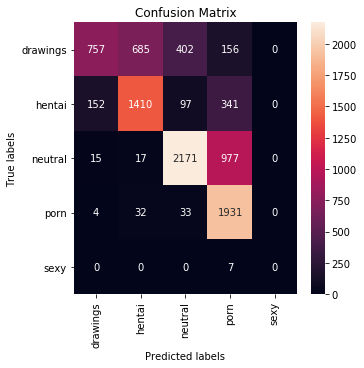

In [19]:
trainer.run(train_loader, max_epochs=5)

In [18]:
for i, child in enumerate(model.children()):
    if i > 6:
        for p in child.parameters():
            p.requires_grad=True

In [19]:
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=INITIAL_LR*0.25)
criterion = nn.CrossEntropyLoss()

step_scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)
scheduler = LRScheduler(step_scheduler)
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
trainer.add_event_handler(Events.EPOCH_COMPLETED, scheduler)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=5)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [20]:
trainer.run(train_loader, max_epochs=6)

State:
	iteration: 4284
	epoch: 6
	epoch_length: 714
	max_epochs: 6
	output: 0.47826501727104187
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12